<a href="https://colab.research.google.com/github/Haffizuddin7899/-PipLine-for-using-openSourse-YOLOV8I-for-Medical-Image-Segmentation/blob/main/pipline_of_YOLOV8I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#           PipLine for using openSourse YOLOV8I for Medical Image Segmentation

# Introduction:
## This project implements a medical image segmentation pipeline using YOLO models from the OpenSourse Ultralytics library.
## The YOLOv8 models, including YOLOv8i, can be effectively used for medical image segmentation tasks.
## The pipeline includes steps for dataset preparation, model training, and inference. The dataset used here
## focuses on segmenting nuclei in medical tissue images, but the pipeline can be adapted to other segmentation tasks.


### Install all necessary libraries

In [ ]:
!pip install -q ultralytics pycocotools scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 751.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 22.4 MB/s eta 0:00:00


### Import libraries

In [ ]:
import os
import shutil
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
from ultralytics import YOLO
import yaml


# Dataset Introduction
### The NuInsSeg dataset contains more than 30k manually segmented nuclei from 31 human and mouse organs and 665 image patches extracted from H&E-stained whole slide images. We also provide ambiguous area masks for the entire dataset to show in which areas manual semantic/instance segmentation were impossible.

# Human organs:
cerebellum, cerebrum (brain), colon (rectum), epiglottis, jejunum, kidney, liver, lung, melanoma, muscle, oesophagus, palatine tonsil, pancreas, peritoneum, placenta, salivary gland, spleen, stomach (cardia), stomach (pylorus), testis, tongue, umbilical cord, and urinary bladder

# Mouse organs:
cerebellum, cerebrum, colon, epiglottis, lung, melanoma, muscle, peritoneum, stomach (cardia), stomach (pylorus), testis, umbilical cord, and urinary bladder)

# Downloading and Unzipping the Dataset
### This function downloads the dataset from a given URL and extracts it into a specified directory.
### The dataset contains images of medical tissues and their corresponding segmentation masks.


In [ ]:
def download_and_unzip(url, save_path, extract_dir):
    print("Downloading assets...")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)
    print("Download completed.")

    if save_path.endswith(".zip"):
        with ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction Done")

DATASET_URL = r"https://www.dropbox.com/scl/fi/u83yuoea9hu7xhhhsgp4d/Nuclei_Instance_Seg.zip?rlkey=7tw3vs4xh7rych4yq1xizd8mh&dl=1"
DATASET_DIR = "Nuclei-Instance-Dataset"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

# Creating Dataset Directory
# If the dataset directory doesn't exist, it is created and the dataset is downloaded and extracted.

if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR, exist_ok=True)
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH, DATASET_DIR)
    os.remove(DATASET_ZIP_PATH)


Download completed.
Extraction Done


# Pruning Unnecessary Subdirectories
### This function removes non-essential subdirectories, keeping only those needed for the segmentation task.
### This helps to focus on the relevant dataset components, reducing the storage and processing requirements.


The dataset comes with many subdirectories. However, for our `YOLOv8l-seg` fine-tuning, we just need the raw images and labeled masks, which we will convert to the appropriate format.

For our task, we will keep the directories with subdirectories named `‘tissue images’` , `‘mask binary without border’`, and `‘label masks modify’`.


In [ ]:
def prune_subdirectories(base_dir, keep_dirs):
    for root_dir in os.listdir(base_dir):
        root_path = os.path.join(base_dir, root_dir)
        if os.path.isdir(root_path):
            for sub_dir in os.listdir(root_path):
                sub_path = os.path.join(root_path, sub_dir)
                if os.path.isdir(sub_path) and sub_dir not in keep_dirs:
                    shutil.rmtree(sub_path)

base_directory = "./Nuclei-Instance-Dataset"
directories_to_keep = ['tissue images', 'mask binary without border', 'label masks modify']

prune_subdirectories(base_directory, directories_to_keep)


# Pairing Images with Corresponding Masks
### This function pairs tissue images with their corresponding segmentation masks.
### A limit is applied to control the number of image-mask pairs used for training and validation.


In [ ]:
def get_image_mask_pairs(data_dir, limit=100):
    image_paths = []
    mask_paths = []

    for root, _, files in os.walk(data_dir):
        if 'tissue images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root.replace('tissue images', 'label masks modify'), file.replace('.png', '.tif')))
                if len(image_paths) >= limit:
                    break
            if len(image_paths) >= limit:
                break
    return image_paths, mask_paths

# Limit the number of images to 1000 for training and 200 for validation
train_limit = 1000
val_limit = 200

image_paths, mask_paths = get_image_mask_pairs(base_directory, limit=(train_limit + val_limit))


# Converting Masks to Polygons
### This function converts binary masks into polygons, which are used as annotations for object detection models.
### Polygons are essential for the YOLO model to learn the boundaries of the segmented objects.


In [ ]:
def mask_to_polygons(mask, epsilon=1.0):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:
                polygons.append(poly)
    return polygons



# Processing and Saving Data in YOLO Format
### This function processes the images and masks, converting them into YOLO-compatible format.
### It saves the processed images and corresponding labels into directories for training and validation.


In [ ]:
def process_data(image_paths, mask_paths, output_images_dir, output_labels_dir):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        shutil.copy(img_path, os.path.join(output_images_dir, os.path.basename(img_path)))

        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "image_id": image_id,
                    "category_id": 1,
                    "segmentation": [poly],
                })

    coco_input = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }

    for img_info in coco_input["images"]:
        img_id = img_info["id"]
        img_ann = [ann for ann in coco_input["annotations"] if ann["image_id"] == img_id]
        img_w, img_h = img_info["width"], img_info["height"]

        if img_ann:
            with open(os.path.join(output_labels_dir, os.path.splitext(img_info["file_name"])[0] + '.txt'), 'w') as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")


# Creating YAML Configuration File
### This function generates a YAML configuration file that specifies the dataset paths and class names.
### This file is essential for training the YOLO model, as it defines the data structure and classes.


In [ ]:
def create_yaml(output_yaml_path, train_images_dir, val_images_dir, nc=1):
    names = ['Nuclei']

    yaml_data = {
        'names': names,
        'nc': nc,
        'train': train_images_dir,
        'val': val_images_dir,
        'test': ' '
    }

    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)



# Preparing the YOLOv8 Dataset
### This function orchestrates the dataset preparation process, including image/mask processing and YAML creation.
### The dataset is split into training and validation sets, and directories are created for storing processed data.


In [ ]:
def yolo_dataset_preparation():
    output_dir = 'yolov8_l_dataset'

    train_images_dir = os.path.join(output_dir, 'train', 'images')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=val_limit/(train_limit+val_limit), random_state=42)

    process_data(train_img_paths, train_mask_paths, train_images_dir, train_labels_dir)
    process_data(val_img_paths, val_mask_paths, val_images_dir, val_labels_dir)

    output_yaml_path = os.path.join(output_dir, 'data.yaml')
    train_path = os.path.join('train', 'images')
    val_path = os.path.join('val', 'images')
    create_yaml(output_yaml_path, train_path, val_path)

yolo_dataset_preparation()


# Training the YOLOv8 Model
### The YOLOv8 model is trained using the prepared dataset, with results saved in a specified project directory.
### Training parameters such as epochs, batch size, and patience can be adjusted to optimize model performance.


In [ ]:
model = YOLO("yolov8l-seg.yaml")  # Load the model architecture
model = YOLO("yolov8l-seg.pt")  # Load pretrained weights (if available)

100%|██████████| 88.1M/88.1M [00:00<00:00, 112MB/s]


In [ ]:
# Define the project directory where results will be saved
project = "yolov8_l_dataset/results"
name = "20_epochs_limited"

ABS_PATH = os.getcwd()

# Train the model with specified parameters
results = model.train(
    data=os.path.join(ABS_PATH, "yolov8_l_dataset/data.yaml"),  # Path to the data configuration file
    project=project,  # Directory where training results will be saved
    name=name,  # Name of the training session
    epochs=20,  # Number of training epochs
    patience=0,  # Early stopping patience (0 disables early stopping)
    batch=4,  # Batch size
)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=/content/yolov8_l_dataset/data.yaml, epochs=20, time=None, patience=0, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolov8_l_dataset/results, name=20_epochs_limited, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

100%|██████████| 755k/755k [00:00<00:00, 24.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 83.9MB/s]


AMP: checks passed ✅


train: Scanning /content/yolov8_l_dataset/train/labels... 554 images, 0 backgrounds, 0 corrupt: 100%|██████████| 554/554 [00:01<00:00, 375.75it/s]


train: New cache created: /content/yolov8_l_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolov8_l_dataset/val/labels... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<00:00, 117.65it/s]


val: New cache created: /content/yolov8_l_dataset/val/labels.cache
Plotting labels to yolov8_l_dataset/results/20_epochs_limited/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolov8_l_dataset/results/20_epochs_limited
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.53G      1.761      2.719      1.338       1.36        181        640: 100%|██████████| 139/139 [01:22<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.53it/s]

                   all        111       4767      0.412      0.613      0.352      0.179      0.431      0.598      0.359      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.32G      1.723      2.591      1.098      1.333        194        640: 100%|██████████| 139/139 [01:10<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]

                   all        111       4767      0.787      0.712      0.787       0.42      0.798      0.684      0.768      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.77G      1.735      2.623      1.135      1.348        145        640: 100%|██████████| 139/139 [01:09<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

                   all        111       4767      0.765      0.698      0.741      0.393      0.756      0.686      0.726      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.23G      1.729      2.661        1.1      1.339         41        640: 100%|██████████| 139/139 [01:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]

                   all        111       4767       0.79      0.723      0.787      0.425      0.783      0.707      0.771      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.49G      1.679      2.532      1.062      1.325        109        640: 100%|██████████| 139/139 [01:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

                   all        111       4767      0.792      0.686      0.774      0.428        0.8      0.678      0.773      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.3G      1.663      2.464      1.024      1.295        132        640: 100%|██████████| 139/139 [01:10<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

                   all        111       4767      0.811      0.748      0.825       0.46      0.802      0.735      0.808      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.87G      1.616       2.39     0.9722      1.287         23        640: 100%|██████████| 139/139 [01:09<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.22it/s]

                   all        111       4767      0.813      0.712      0.803      0.453       0.81      0.703      0.793      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.31G      1.619      2.389       0.96      1.296         71        640: 100%|██████████| 139/139 [01:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.22it/s]

                   all        111       4767      0.816      0.744       0.83      0.466      0.808      0.727      0.805        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.85G        1.6       2.36     0.9514      1.277        155        640: 100%|██████████| 139/139 [01:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

                   all        111       4767      0.833      0.746      0.843      0.459      0.828      0.732      0.824      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.82G      1.587       2.33     0.9142      1.276        196        640: 100%|██████████| 139/139 [01:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

                   all        111       4767      0.823      0.753      0.839      0.487      0.823      0.749      0.831      0.441


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.34G      1.591      2.378      1.009      1.319        174        640: 100%|██████████| 139/139 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]

                   all        111       4767      0.839      0.776      0.853      0.489      0.839      0.763      0.838      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.32G      1.564      2.309     0.9154       1.32        125        640: 100%|██████████| 139/139 [00:53<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]

                   all        111       4767      0.854      0.764      0.858      0.492      0.854      0.763      0.849      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.21G      1.551      2.276     0.8912      1.291         78        640: 100%|██████████| 139/139 [00:53<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.01it/s]

                   all        111       4767      0.846       0.78      0.861      0.494      0.841       0.78      0.852       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.58G      1.535      2.245     0.8837      1.273         70        640: 100%|██████████| 139/139 [00:55<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

                   all        111       4767      0.828       0.79      0.859      0.498      0.818      0.779      0.841      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.73G      1.525       2.25     0.8951      1.279        106        640: 100%|██████████| 139/139 [00:54<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

                   all        111       4767      0.854      0.782      0.872      0.507      0.847      0.769      0.853      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.21G      1.522       2.22     0.8765      1.286         11        640: 100%|██████████| 139/139 [00:53<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

                   all        111       4767       0.84      0.771      0.857      0.501      0.832      0.757      0.839      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.37G      1.502      2.205     0.8361      1.257         54        640: 100%|██████████| 139/139 [00:53<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

                   all        111       4767      0.857      0.772      0.863      0.505      0.848       0.76      0.844      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.07G      1.508      2.201     0.8398      1.276        243        640: 100%|██████████| 139/139 [00:54<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.27it/s]

                   all        111       4767      0.854       0.79      0.873      0.517      0.844      0.773      0.852      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.32G      1.476      2.154     0.8102       1.28         60        640: 100%|██████████| 139/139 [00:54<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

                   all        111       4767      0.862      0.787      0.877      0.519      0.848      0.774      0.856      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.85G      1.464      2.122     0.8028      1.255         42        640: 100%|██████████| 139/139 [00:53<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]

                   all        111       4767       0.87      0.793      0.882      0.526      0.858      0.782      0.861      0.462



20 epochs completed in 0.446 hours.
Optimizer stripped from yolov8_l_dataset/results/20_epochs_limited/weights/last.pt, 92.3MB
Optimizer stripped from yolov8_l_dataset/results/20_epochs_limited/weights/best.pt, 92.3MB

Validating yolov8_l_dataset/results/20_epochs_limited/weights/best.pt...
Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8l-seg summary (fused): 295 layers, 45,912,659 parameters, 0 gradients, 220.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.03it/s]


                   all        111       4767      0.869      0.793      0.882      0.526      0.858      0.782      0.861      0.462
Speed: 0.8ms preprocess, 23.3ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to yolov8_l_dataset/results/20_epochs_limited


# Visualizing Training Results
### The training process generates various output files, including a results image that summarizes model performance.
### This section displays these visual outputs, such as the results summary.

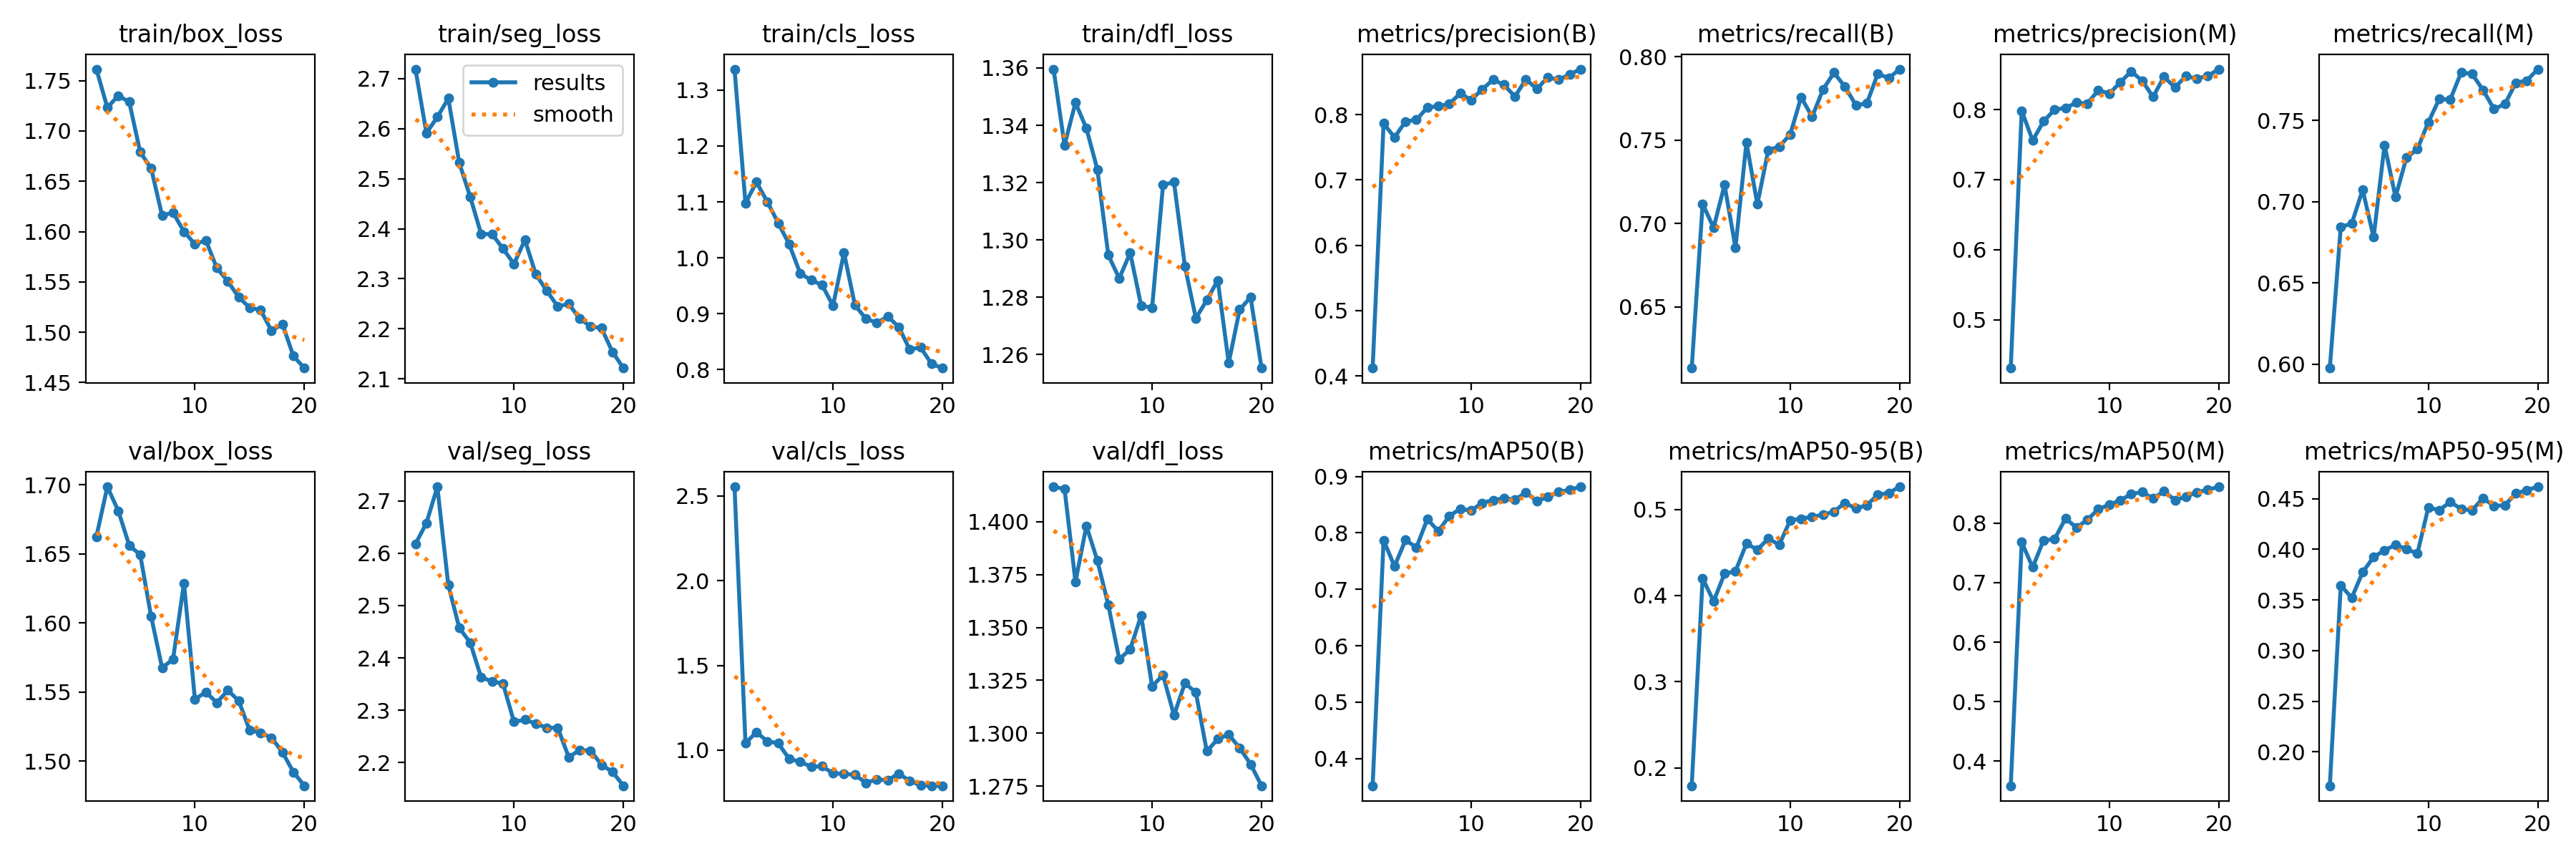

In [ ]:
from IPython.display import Image

# Display the image
Image("/content/yolov8_l_dataset/results/20_epochs_limited/results.png")


# Model Inference on Validation Images
### After training, the model can be used to make predictions on unseen validation images.
### This section loads the best model from training and performs inference, visualizing the segmentation results.



image 1/1 /content/yolov8_l_dataset/val/images/human_epiglottis_4.png: 640x640 5 Nucleis, 72.5ms
Speed: 2.5ms preprocess, 72.5ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


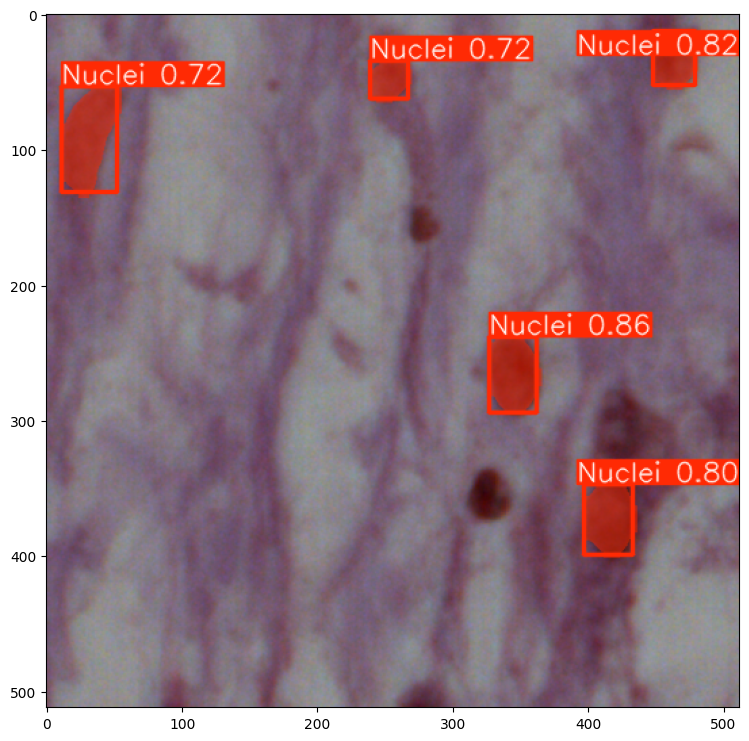

In [ ]:
inference_model = YOLO('/content/yolov8_l_dataset/results/20_epochs_limited/weights/best.pt')

inference_img_path = "/content/yolov8_l_dataset/val/images/human_epiglottis_4.png"
inference_result = inference_model.predict(inference_img_path, conf=0.7, save=True)

inference_result_array = inference_result[0].plot()
plt.figure(figsize=(9,9))
plt.imshow(inference_result_array)



image 1/1 /content/yolov8_l_dataset/val/images/human_brain_7.png: 640x640 2 Nucleis, 117.0ms
Speed: 12.0ms preprocess, 117.0ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


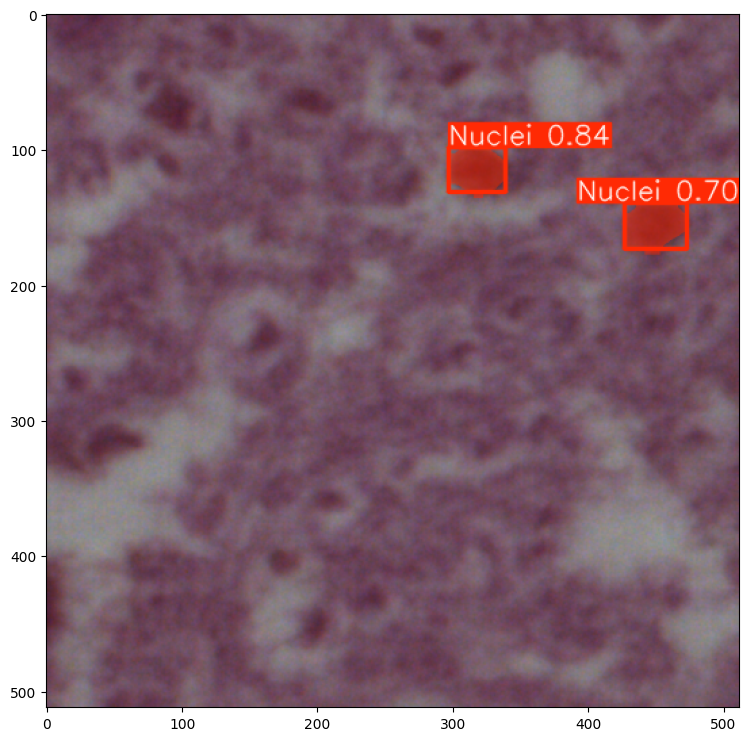

In [ ]:
inference_img_path = "/content/yolov8_l_dataset/val/images/human_brain_7.png"
inference_result = inference_model.predict(inference_img_path, conf=0.7, save=True)

inference_result_array = inference_result[0].plot()
plt.figure(figsize=(9,9))
plt.imshow(inference_result_array)


image 1/1 /content/yolov8_l_dataset/val/images/mouse_thymus_02.png: 640x640 55 Nucleis, 82.3ms
Speed: 9.0ms preprocess, 82.3ms inference, 23.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


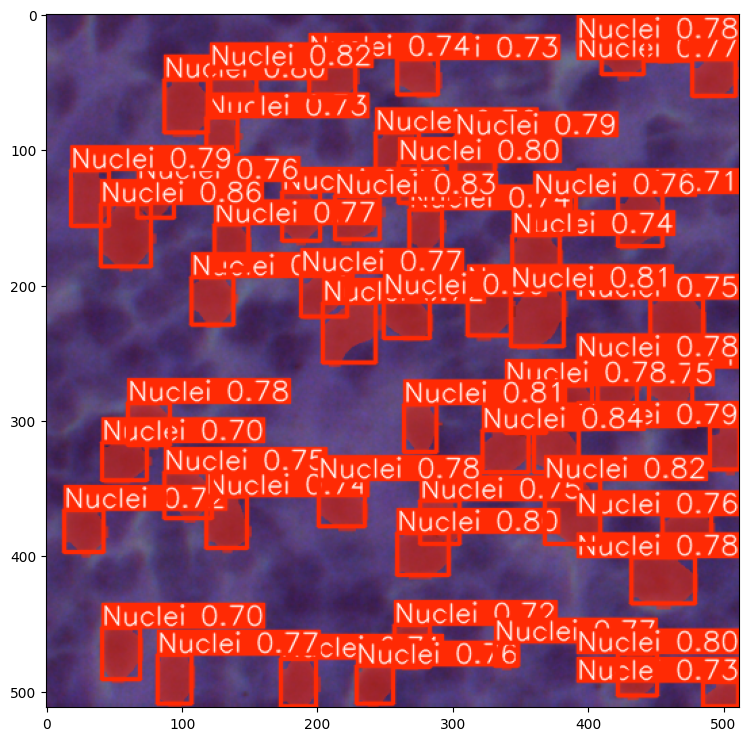

In [ ]:
inference_img_path = "/content/yolov8_l_dataset/val/images/mouse_thymus_02.png"
inference_result = inference_model.predict(inference_img_path, conf=0.7, save=True)

inference_result_array = inference_result[0].plot()
plt.figure(figsize=(9,9))
plt.imshow(inference_result_array)

# Backing Up Results to Google Drive
### After training and inference, the entire dataset and model results are backed up to Google Drive for future use.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

source_dir = '/content/yolov8_l_dataset'
destination_dir = '/content/drive/MyDrive/Yolov8l_exp'

shutil.copytree(source_dir, destination_dir)


Mounted at /content/drive


'/content/drive/MyDrive/Yolov8l_exp'

The MMDetection framework, which is part of the OpenMMLab project, is a popular open-source toolbox for object detection and segmentation. It supports a wide range of models and tasks. However, as of the latest updates, MMDetection primarily focuses on general object detection and instance segmentation tasks, particularly in natural images, such as those in the COCO or VOC datasets.

For medical image segmentation, especially tasks like nuclei segmentation, the MMDetection framework might not have a specific pre-trained model directly tailored for this use case. However, you can use pre-trained models from MMDetection on natural images as a starting point and fine-tune them on your medical image data.

# Steps to Adapt MMDetection for Medical Image Segmentation:
## Choose a Pre-trained Model:

You can select a model that has been pre-trained on COCO or VOC datasets, such as Mask R-CNN, Cascade R-CNN, or SOLO.
These models are good starting points for instance segmentation tasks and can be adapted to medical images.
## Fine-tune the Model:

Fine-tuning involves taking a pre-trained model and training it further on your specific medical dataset (like NuInsSeg). You'll need to prepare your dataset in a format compatible with MMDetection (e.g., COCO or Pascal VOC format).
Adjust the model configuration files (.py or .yaml) provided by MMDetection to match your dataset classes, data paths, and other hyperparameters.
## Customize the Backbone and Neck:

You might need to adjust the backbone network (like ResNet, ResNeXt) or the neck (like FPN) to better handle the characteristics of medical images, which might differ from natural images.
## Experiment with Augmentations and Loss Functions:

Medical images often benefit from different data augmentations compared to natural images. Consider using augmentations that are more suitable for medical data.
You might also experiment with different loss functions that are more tailored to pixel-wise segmentation tasks.
# Alternatives:
If MMDetection does not fully meet your needs, you might also consider other open-source frameworks that are more specialized in medical image analysis, such as:

# MONAI (Medical Open Network for AI):
A PyTorch-based framework designed specifically for medical image analysis, with a range of pre-trained models and utilities for segmentation tasks.
# nnU-Net:
A framework specifically designed for biomedical image segmentation, which has achieved state-of-the-art results on many medical datasets.